# 01 — Deep EDA (Walmart Weekly Sales)
This notebook performs **comprehensive EDA**:

- Schema & joins, coverage, missingness

- Sanity checks & outliers

- Trend/seasonality with STL

- Holiday & promotion effects (with lead/lag windows)

- Macro & weather relationships (nonlinear)

- Cross‑store heterogeneity, clustering

- Anomaly detection


In [7]:

# Imports
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import acf, pacf
from pathlib import Path

RAW = Path("../data/raw")
train = pd.read_csv(RAW/"train.csv")
stores = pd.read_csv(RAW/"stores.csv")
features = pd.read_csv(RAW/"features.csv")

# Parse dates
for df in [train, features]:
    df['Date'] = pd.to_datetime(df['Date'])

# Basic shapes
print(train.shape, stores.shape, features.shape)
train.head()


(421570, 5) (45, 3) (8190, 12)


,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [ ]:
# Join & keys
df = (train.merge(stores, on='Store', how='left')
           .merge(features, on=['Store','Date'], how='left'))
df = df.drop(columns=['IsHoliday_y'])  # remove duplicate IsHoliday
df = df.rename(columns={'IsHoliday_x': 'IsHoliday'})
assert df['Weekly_Sales'].notna().all()
df['Year'] = df['Date'].dt.year
df['Week'] = df['Date'].dt.isocalendar().week.astype(int)
df['IsHoliday'] = df['IsHoliday'].astype(bool)
df.sort_values(['Store','Dept','Date'], inplace=True)
df.head()


,Store,Dept,Date,Weekly_Sales,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Year,Week
0,1,1,2010-02-05,24924.50,False,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,2010,5
1,1,1,2010-02-12,46039.49,True,A,151315,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,2010,6
2,1,1,2010-02-19,41595.55,False,A,151315,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,2010,7
3,1,1,2010-02-26,19403.54,False,A,151315,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,2010,8
4,1,1,2010-03-05,21827.90,False,A,151315,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,2010,9


MarkDown2       0.736110
MarkDown4       0.679847
MarkDown3       0.674808
MarkDown1       0.642572
MarkDown5       0.640790
Dept            0.000000
Year            0.000000
Unemployment    0.000000
CPI             0.000000
Store           0.000000
Fuel_Price      0.000000
Temperature     0.000000
Size            0.000000
Type            0.000000
IsHoliday       0.000000
dtype: float64


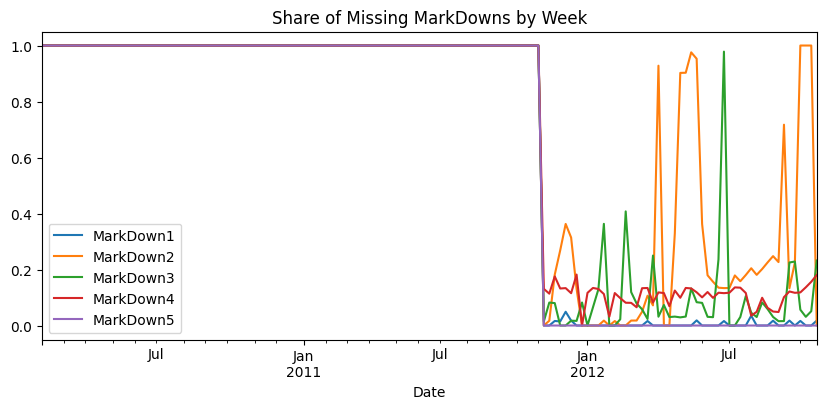

In [14]:

# Missingness summary
miss = df.isna().mean().sort_values(ascending=False)
print(miss.head(15))

# Visualize missingness for MarkDowns
md_cols = [c for c in df.columns if c.startswith("MarkDown")]
miss_md = df.groupby('Date')[md_cols].apply(lambda x: x.isna().mean())
miss_md.plot(figsize=(10,4), title="Share of Missing MarkDowns by Week")
plt.show()


In [15]:

# Outlier detection: Z-scores by series (Store, Dept)
def zscore(x):
    mu, sd = x.mean(), x.std(ddof=1)
    return (x - mu) / (sd if sd > 0 else 1)

df['z'] = df.groupby(['Store','Dept'])['Weekly_Sales'].transform(zscore)
outliers = df[np.abs(df['z']) > 4]
print("Outliers:", len(outliers))
outliers[['Store','Dept','Date','Weekly_Sales','z']].head()


Outliers: 2548


,Store,Dept,Date,Weekly_Sales,z
189,1,2,2010-12-24,59889.32,4.007131
241,1,2,2011-12-23,65615.36,5.671352
315,1,3,2010-08-27,51159.17,4.364311
367,1,3,2011-08-26,49775.52,4.205435
420,1,3,2012-08-31,50701.30,4.311736


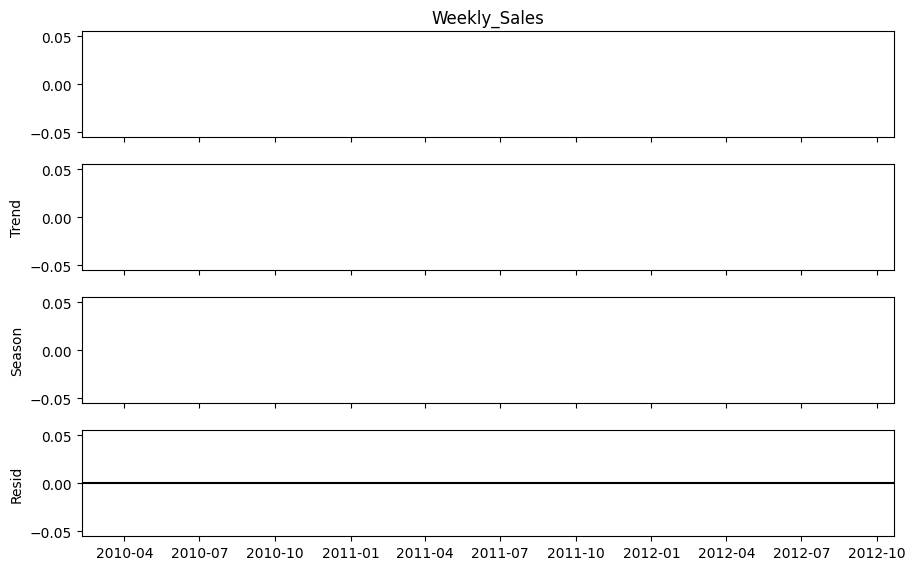

In [16]:

# STL decomposition on a sample series
g = df.groupby(['Store','Dept'])
example_key = g.size().sort_values(ascending=False).index[0]
yt = g.get_group(example_key).set_index('Date')['Weekly_Sales'].asfreq('W-MON').interpolate()
res = STL(yt, period=52, robust=True).fit()
fig = res.plot()
fig.set_size_inches(10,6)
plt.show()


In [17]:

# Holiday effect: compare distributions
import numpy as np

def holiday_lift(grp):
    a = grp.loc[grp['IsHoliday'], 'Weekly_Sales']
    b = grp.loc[~grp['IsHoliday'], 'Weekly_Sales']
    return pd.Series({
        'holiday_mean': a.mean(),
        'nonholiday_mean': b.mean(),
        'holiday_lift_pct': (a.mean() - b.mean()) / (b.mean()+1e-9) * 100
    })

lift = df.groupby(['Store','Dept']).apply(holiday_lift).reset_index()
lift['holiday_lift_pct'].describe()


/var/folders/cg/22wrbnls6yb3rmnx4k648pl00000gn/T/ipykernel_25471/2656387870.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  lift = df.groupby(['Store','Dept']).apply(holiday_lift).reset_index()


count    3.205000e+03
mean     5.550702e+10
std      2.399949e+12
min     -5.980721e+03
25%     -6.092955e+00
50%      1.952521e+00
75%      1.685413e+01
max      1.272000e+14
Name: holiday_lift_pct, dtype: float64

In [ ]:
# Promotion (Markdown) lead/lag windows
md_cols = [c for c in df.columns if c.startswith("MarkDown")]
for c in md_cols:
    for k in [1,2,3,4]:
        df[f'{c}_lag{k}'] = df.groupby(['Store','Dept'])[c].shift(k)
        df[f'{c}_lead{k}'] = df.groupby(['Store','Dept'])[c].shift(-k)

# Simple cross-correlation proxy: corr with future sales (lead 1-2w) to detect pre-lift
for k in [1,2]:
    df[f'Sales_lead{k}'] = df.groupby(['Store','Dept'])['Weekly_Sales'].shift(-k)

corrs = []
for c in [c for c in df.columns if 'MarkDown' in c and ('lag' in c or 'lead' in c)]:
    corrs.append((c, df[[c,'Weekly_Sales']].corr().iloc[0,1]))
corrs = sorted(corrs, key=lambda x: -abs(x[1]))
corrs[:10]


[('MarkDown5_lag3', 0.11418767399215363),
 ('MarkDown5_lag2', 0.10941549337029777),
 ('MarkDown5_lead1', 0.10304923392642376),
 ('MarkDown5_lag1', 0.10116389213483856),
 ('MarkDown1_lag2', 0.09687054761933828),
 ('MarkDown2_lead1', 0.09530008129866216),
 ('MarkDown1_lag1', 0.09509240261187145),
 ('MarkDown5_lead2', 0.094438867748494),
 ('MarkDown1_lag4', 0.09102225054599963),
 ('MarkDown3_lag4', 0.09020349926775892)]

/var/folders/cg/22wrbnls6yb3rmnx4k648pl00000gn/T/ipykernel_25471/2807190173.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  temp = df.groupby('Temp_bin')['Weekly_Sales'].mean()


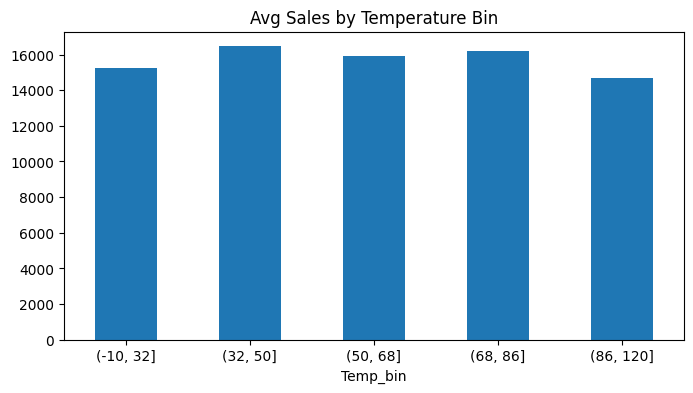

/var/folders/cg/22wrbnls6yb3rmnx4k648pl00000gn/T/ipykernel_25471/2807190173.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ax = df.groupby(col+'_bin')['Weekly_Sales'].mean().plot(


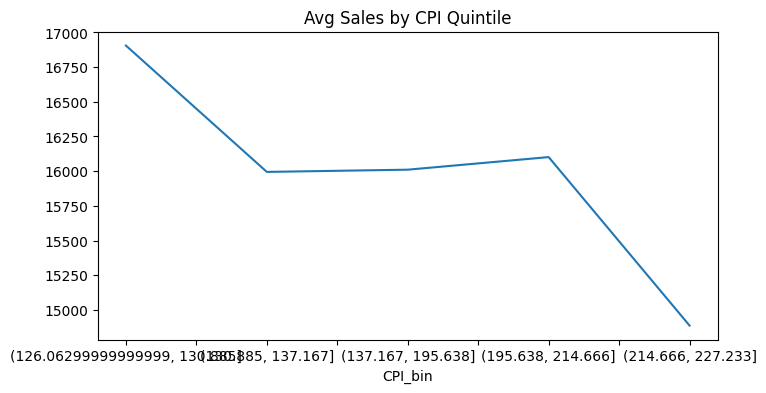

/var/folders/cg/22wrbnls6yb3rmnx4k648pl00000gn/T/ipykernel_25471/2807190173.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ax = df.groupby(col+'_bin')['Weekly_Sales'].mean().plot(


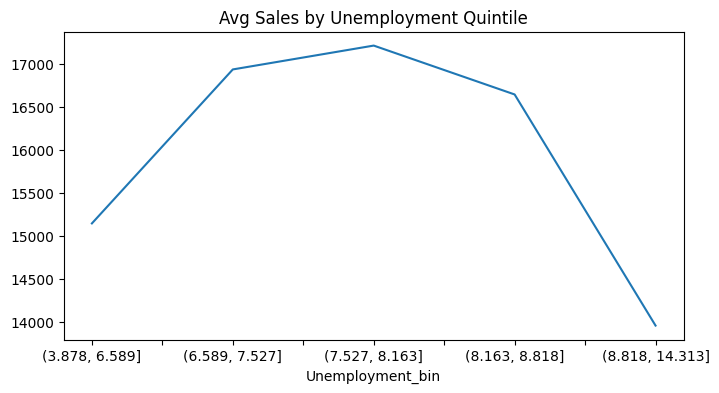

/var/folders/cg/22wrbnls6yb3rmnx4k648pl00000gn/T/ipykernel_25471/2807190173.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ax = df.groupby(col+'_bin')['Weekly_Sales'].mean().plot(


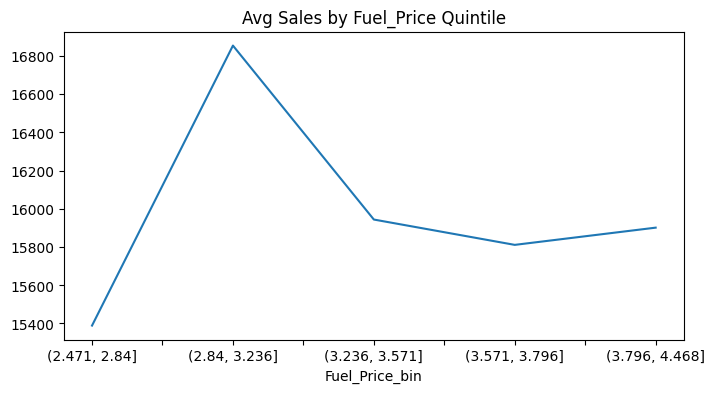

In [ ]:
# Macro & weather relationships (nonlinear via binning)
df['Temp_bin'] = pd.cut(df['Temperature'], bins=[-10,32,50,68,86,120])
temp = df.groupby('Temp_bin')['Weekly_Sales'].mean()
temp.plot(kind='bar', title='Avg Sales by Temperature Bin', figsize=(8,4))
plt.xticks(rotation=0)
plt.show()

for col in ['CPI', 'Unemployment', 'Fuel_Price']:
    df[col+'_bin'] = pd.qcut(df[col], 5, duplicates='drop')
    ax = df.groupby(col+'_bin')['Weekly_Sales'].mean().plot(
        title=f'Avg Sales by {col} Quintile', figsize=(8,4))
    plt.show()


In [20]:

# Cross-store heterogeneity: store-level WAPE (against store mean)
store_stats = (df.groupby('Store')
                 .apply(lambda g: pd.Series({
                     'avg_sales': g['Weekly_Sales'].mean(),
                     'wape_like': (g['Weekly_Sales']-g['Weekly_Sales'].mean()).abs().sum() / g['Weekly_Sales'].sum()
                 }))
              )
store_stats.sort_values('wape_like').head(), store_stats.sort_values('wape_like', ascending=False).head()


/var/folders/cg/22wrbnls6yb3rmnx4k648pl00000gn/T/ipykernel_25471/551026821.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({


(          avg_sales  wape_like
 Store                         
 11     19276.762751   0.790319
 23     19776.180881   0.801458
 6      21913.243624   0.811983
 35     13803.596986   0.822072
 21     11283.435496   0.822725,
           avg_sales  wape_like
 Store                         
 30      8764.237719   1.183121
 44      6038.929814   1.175364
 38      7492.478460   1.167469
 37     10297.355026   1.145252
 42     11443.370118   1.136034)

In [ ]:
# Simple anomaly detection: rolling median residuals
df['roll_med'] = df.groupby(['Store','Dept'])['Weekly_Sales'].transform(lambda s: s.rolling(13, min_periods=3, center=True).median())
df['resid'] = df['Weekly_Sales'] - df['roll_med']
thr = df['resid'].abs().quantile(0.995)
anoms = df[df['resid'].abs() > thr]
print("Anomalies:", len(anoms))
anoms[['Store','Dept','Date','Weekly_Sales','resid']].head()


Anomalies: 2108


,Store,Dept,Date,Weekly_Sales,resid
8,1,1,2010-04-02,57258.43,36215.04
46,1,1,2010-12-24,55931.23,36381.84
63,1,1,2011-04-22,50510.31,30112.22
106,1,1,2012-02-17,54060.10,32920.03
113,1,1,2012-04-06,57592.12,37467.90
